Mueller-Brown poteintial tutorial - modified for use with Gaussian Process Regression (GPR)

For the definition of Mueller-Brown potential, see https://www.wolframcloud.com/objects/demonstrations/TrajectoriesOnTheMullerBrownPotentialEnergySurface-source.nb.

$v(x,y) = \sum_{k=0}^3 A_k \mathrm{exp}\left[ a_k (x - x_k^0)^2 + b_k (x - x_k^0) (y - y_k^0) + c_k (y - y_k^0)^2 \right] $

**Generate Traning Data**

In [1]:
from math import exp, pow, tanh
import numpy as np
import matplotlib.pyplot as plt

def mueller_brown_potential(x, y):
  A = [-200, -100, -170, 15]
  a = [-1, -1, -6.5, 0.7]
  b = [0, 0, 11, 0.6]
  c = [-10, -10, -6.5, 0.7]
  x0 = [1, 0, -0.5, -1.0]
  y0 = [0, 0.5, 1.5, 1]
  value = 0
  dx_value = 0
  dy_value = 0
  for k in range(0, 4):
    value += 0.1 * A[k] * exp( a[k] * pow(x-x0[k], 2.0) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2.0))
    dx_value += 0.1 * A[k] * exp( a[k] * pow(x-x0[k], 2.0) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2.0)) * (a[k]*2.0*(x-x0[k]) + b[k] * (y-y0[k]))
    dy_value += 0.1 * A[k] * exp( a[k] * pow(x-x0[k], 2.0) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2.0)) * (b[k] * (x-x0[k])+ c[k]*2.0* (y-y0[k]))
  return value, dx_value, dy_value

#main function
xx = np.arange(-1.8, 1.4, 0.1)
yy = np.arange(-0.4, 2.4, 0.1)
X, Y = np.meshgrid(xx, yy)
xy, xy_truncated = [],[]
z, z_truncated = [], []
dx, dx_truncated = [], []
dy, dy_truncated = [], []
for y in yy:
  for x in xx:
    v, dvx, dvy = mueller_brown_potential(x,y)
    z.append(v)
    dx.append(dvx)
    dy.append(dvy)
    xy.append([x,y])
    if v < 10:  #keep only low-energy points for ML training
      xy_truncated.append([x, y])
      z_truncated.append(v)
      dx_truncated.append(dvx)
      dy_truncated.append(dvy)
Z = np.reshape(z,(len(yy),-1))
DX = np.reshape(dx,(len(yy),-1))
DY = np.reshape(dy,(len(yy),-1))
print("Zmin:", np.amin(Z), "Zmax:", np.amax(Z))
print("Size of (future) training set:", len(z_truncated))
print("Size of Testing set:", len(z))

Zmin: -14.599803525171698 Zmax: 1194.4772333054245
Size of (future) training set: 696
Size of Testing set: 896


**Loading PyTorch, GpyTorch, and training data**

In [2]:
!pip install gpytorch > /dev/null

import numpy as np
import torch
import gpytorch
from torch import Tensor


Let us define the variables in our function as a vector of input features $\textbf{x}=[x,y]$ 

A set of $n$ configurations can be assembled in to a training set $\textbf{X}=[\textbf{x}_1, ...,\textbf{x}_n]$ with a set of observations $\textbf{y}=[y_1,...,y_n]$. For noisy samples, we can assume that an observations is seperate from the underlying function according to $y=f(\textbf{x})+\mathit{ε}$, where the noise, $\mathit{ε}$, follows a gaussian distribution $\mathit{ε}\sim\mathcal{N}(0,σ^2_n)$. The prior distribution of underlying functions follows a Gaussian distribution $\textbf{f}(\textbf{X})\sim\mathcal{N}(\textbf{0}, \textbf{K}(\textbf{X},\textbf{X}))$, where $\textbf{0}$ is the mean function and $\textbf{K}$ is the covaraince kernel matrix. The covariance kernel matrix is assembled based on a kernel function, $k$, that is used to compare the simularities between input vectors:

\begin{equation}
\textbf{K(X,X)}=
\begin{bmatrix}
k(\textbf{x}_1,\textbf{x}_1) & \ldots & k(\textbf{x}_1,\textbf{x}_n)\\
\vdots & \ddots & \vdots\\
k(\textbf{x}_n,\textbf{x}_1) & \ldots & k(\textbf{x}_n,\textbf{x}_n)\\
\end{bmatrix}
\end{equation}

Here we used the radial basis function:
\begin{equation}
\mathrm{k}(\textbf{x}_a,\textbf{x}_b)=\sigma^2_f\mathrm{exp}(-\frac{||\textbf{x}_a-\textbf{x}_b||^2}{2l^2})
\end{equation}

Derivatives of gaussian processes, $\frac{\partial \textbf{f(X)}}{\partial x}$, are themselves Gaussian processes; consequently, they can be incorperated into the training targets and used to make explicit predictions of the gradient:
\begin{equation}
\mathrm{\textbf{y}}_\mathrm{ext}=
\left[y_1,...,y_N,\frac{\partial f(\textbf{x}_1)}{\partial x},...,\frac{\partial f(\textbf{x}_N)}{\partial x},\frac{\partial f(\textbf{x}_1)}{\partial y},...,\frac{\partial f(\textbf{x}_N)}{\partial y}\right]^\mathrm{T}
\end{equation}
To account for the additional observations, the kernel is extended:
\begin{equation}
\textbf{K}_\mathrm{ext}=
\begin{bmatrix}
\textbf{K}(\textbf{X,X}') & \displaystyle\frac{\partial \textbf{K}(\textbf{X,X}')}{\partial \textbf{X}'} \\ 
\displaystyle\frac{\partial \textbf{K}(\textbf{X,X}')}{\partial \textbf{X}} & \displaystyle\frac{\partial^2 \textbf{K}(\textbf{X,X}')}{\partial \textbf{X} \partial \textbf{X}'}
\end{bmatrix}
\end{equation}


In [45]:
# GPR with derivative observation, following "Simple_GP_Regression_Derivative_Information.ipynb""
class GPModelWithDerivatives(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelWithDerivatives, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = gpytorch.kernels.RBFKernelGrad(ard_num_dims=2)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

Z_gpr = Tensor(z_truncated)
DX_gpr = Tensor(dx_truncated)
DY_gpr = Tensor(dy_truncated)

Z = Tensor(Z)
DX = Tensor(DX)
DY = Tensor(DY)

X_gpr = Tensor(xy_truncated)
Y_gpr = torch.stack([Z_gpr, DX_gpr, DY_gpr], 1)

X_test = Tensor(xy)
print(Z.shape, DX.shape, DY.shape)
Y_test = torch.stack([Z.flatten(), DX.flatten(), DY.flatten()], 1)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)  # Value + x-derivative + y-derivative
model = GPModelWithDerivatives(X_gpr, Y_gpr, likelihood)

use_gpu = torch.cuda.is_available()
if use_gpu:
  X_gpr = X_gpr.cuda()
  Y_gpr = Y_gpr.cuda()
  X_test = X_test.cuda()
  Y_test = Y_test.cuda()
  likelihood = likelihood.cuda()
  model = model.cuda()

torch.Size([28, 32]) torch.Size([28, 32]) torch.Size([28, 32])


Let $\textbf{K}_\textrm{ext}=\textbf{K}_\textrm{ext}(\textbf{X},\textbf{X})+σ^2_n\textbf{I}$

Hyperparameters $\Theta = \{σ^2_f, l, \sigma^2_n\}$ are optimized by maximizing the marginal likelihood log: 

\begin{equation}
\mathrm{log}\:p(\textbf{y}_\textrm{ext}|\textbf{X},\textbf{Θ})=-\frac{1}{2}\textbf{y}_\textrm{ext}^\mathrm{T}\textbf{K}_\textrm{ext}^{-1}\textbf{y}_\textrm{ext}-\frac{1}{2}\mathrm{log}\:|\textbf{K}_\textrm{ext}|-\frac{n(m+1)}{2}\mathrm{log}\:2\pi
\end{equation}

Hyperparameters will be optimized using gradient optimization

In [7]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 300

# Find optimal model hyperparameters
model.train()
likelihood.train()

def train_model(model, likelihood, x_train, y_train, print_hp=True):
  # Use the adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
  for i in range(training_iter):
      optimizer.zero_grad()
      output = model(x_train)
      loss = -mll(output, y_train)
      loss.backward()
      if print_hp:
        print("Iter %d/%d - Loss: %.3f    outputscale: %.3f,   lengthscales: %.3f, %.3f   noise: %.3f" % (
          i + 1, training_iter, loss.item(),
          model.covar_module.outputscale,
          model.covar_module.base_kernel.lengthscale.squeeze()[0],
          model.covar_module.base_kernel.lengthscale.squeeze()[1],
          model.likelihood.noise.item()
        ))
      optimizer.step()

train_model(model, likelihood, X_gpr, Y_gpr)

Iter 1/300 - Loss: 19.530    outputscale: 0.693,   lengthscales: 0.693, 0.693   noise: 0.693
Iter 2/300 - Loss: 19.107    outputscale: 0.698,   lengthscales: 0.688, 0.688   noise: 0.698
Iter 3/300 - Loss: 18.693    outputscale: 0.703,   lengthscales: 0.683, 0.683   noise: 0.703
Iter 4/300 - Loss: 18.286    outputscale: 0.708,   lengthscales: 0.678, 0.678   noise: 0.708
Iter 5/300 - Loss: 17.886    outputscale: 0.713,   lengthscales: 0.673, 0.673   noise: 0.713
Iter 6/300 - Loss: 17.491    outputscale: 0.718,   lengthscales: 0.668, 0.668   noise: 0.718
Iter 7/300 - Loss: 17.105    outputscale: 0.724,   lengthscales: 0.664, 0.664   noise: 0.724
Iter 8/300 - Loss: 16.726    outputscale: 0.729,   lengthscales: 0.659, 0.659   noise: 0.729
Iter 9/300 - Loss: 16.352    outputscale: 0.734,   lengthscales: 0.654, 0.654   noise: 0.734
Iter 10/300 - Loss: 15.990    outputscale: 0.739,   lengthscales: 0.649, 0.649   noise: 0.739
Iter 11/300 - Loss: 15.632    outputscale: 0.744,   lengthscales: 0.6

In [8]:
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
    predictions = likelihood(model(X_test))
    mean = predictions.mean

The optimized model can be used to make predictions of both the function and its gradients on new input space, $\textbf{x}_*$. The expected (E) value of tehe function at $\textbf{x}_*$ is given by: 

\begin{equation}
\mathrm{E}\left[f(\mathrm{\textbf{x}^\ast})|\mathrm{\textbf{y}}_\mathrm{ext},\mathrm{\textbf{x}^\ast},\mathrm{\textbf{X}},\Theta\right] = \textbf{K}^\ast_\mathrm{ext}(\textbf{K}_\mathrm{ext}+\sigma^2_\mathrm{n}\textbf{I})^{-1}\textbf{y}_\mathrm{ext}
\end{equation}

where $\textbf{K}^\ast_\mathrm{ext}=\textbf{K}_\mathrm{ext}(\textbf{x}^\ast,\textbf{X})$. The associated predictive variance (Var) is given by:

\begin{equation}
\mathrm{Var}\left[f(\mathrm{\textbf{x}^\ast})|\mathrm{\textbf{y}}_\mathrm{ext},\mathrm{\textbf{x}^\ast},\mathrm{\textbf{X}},\Theta\right] = k(\mathrm{\textbf{x}^\ast},\mathrm{\textbf{x}^\ast})-\textbf{K}^\ast_\mathrm{ext}(\textbf{K}_\mathrm{ext}+\sigma^2_\mathrm{n}\textbf{I})^{-1}\textbf{K}^{\ast\mathrm{T}}_\mathrm{ext}
\end{equation}

The predictions of the expected gradients are given by:

\begin{equation}
\mathrm{E}\left[\frac{\partial f(\mathrm{\textbf{x}^\ast})}{\partial q}\bigg|\mathrm{\textbf{y}}_\mathrm{ext},\mathrm{\textbf{x}^\ast},\mathrm{\textbf{X}},\Theta\right] = \frac{\partial \textbf{K}^\ast_\mathrm{ext}}{\partial q}(\textbf{K}_\mathrm{ext}+\sigma^2_\mathrm{n}\textbf{I})^{-1}\textbf{y}_\mathrm{ext}
\end{equation}

where q corresponds to the input x or y. The associated variances are determined by:

\begin{equation}
\mathrm{Var}\left[\frac{\partial f(\mathrm{\textbf{x}^\ast})}{\partial q}\bigg|\mathrm{\textbf{y}}_\mathrm{ext},\mathrm{\textbf{x}^\ast},\mathrm{\textbf{X}},\Theta\right] =\\
\frac{\partial^2 k(\mathrm{\textbf{x}^\ast},\mathrm{\textbf{x}^\ast})}{\partial q^2}-\frac{\partial \textbf{K}^\ast_\mathrm{ext}}{\partial q}(\textbf{K}_\mathrm{ext}+\sigma^2_\mathrm{n}\textbf{I})^{-1}\frac{\partial \textbf{K}^{\ast\mathrm{T}}_\mathrm{ext}}{\partial q}
\end{equation}



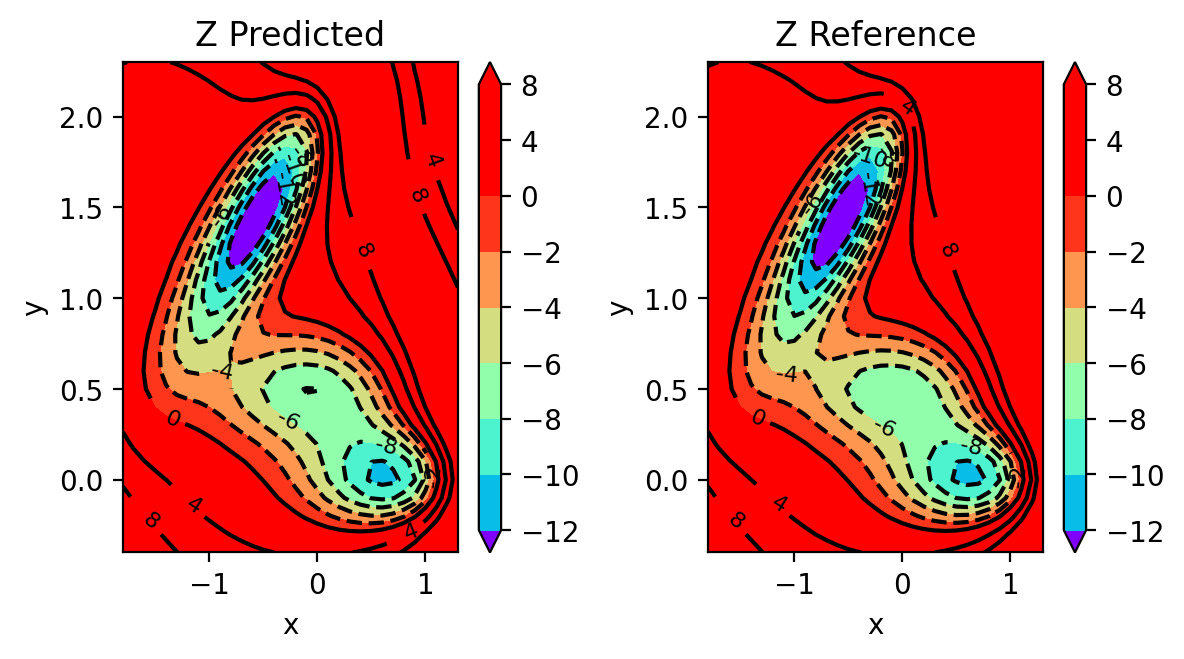

In [10]:
# Show the predicted surface, and compare to the reference one
if use_gpu:
  mean = mean.cpu()
  
def show_surface():
  n1, n2 = 896, 1

  z_pred = mean[:, 0]
  Z_pred = np.reshape(z_pred.detach().numpy(),(len(yy),-1))
  Zdiff = np.subtract(Z_pred, Z)

  dx_pred = mean[:, 1]
  DX_pred = np.reshape(dx_pred.detach().numpy(),(len(yy),-1))
  DX_diff = np.subtract(DX_pred, DX)

  dy_pred = mean[:, 2]
  DY_pred = np.reshape(dy_pred.detach().numpy(),(len(yy),-1))
  DY_diff = np.subtract(DY_pred, DY)

  fig = plt.figure(figsize=(6,6), dpi=200)

  plt.subplot(2, 2, 1)
  levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8]
  ct = plt.contour(X, Y, Z_pred, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z_pred, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("Z Predicted")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(2, 2, 2)
  levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8]
  ct = plt.contour(X, Y, Z, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("Z Reference")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.tight_layout()

  plt.show()

show_surface()

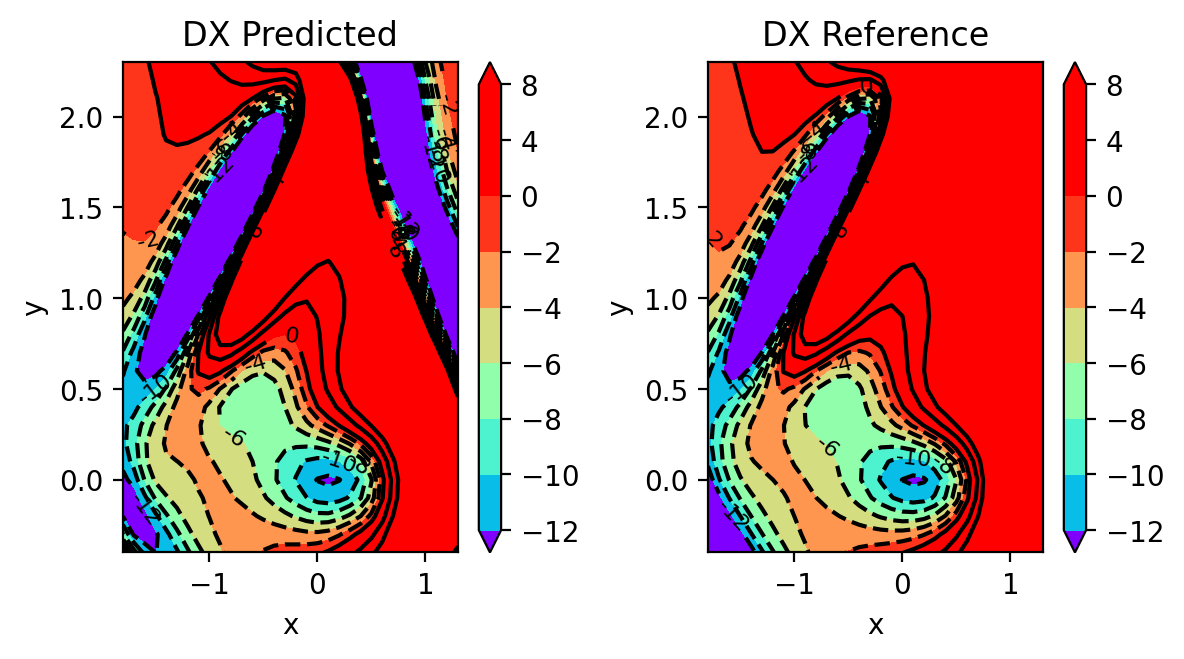

In [11]:
# Show the predicted surface, and compare to the reference one
def show_DX_surface():

  n1, n2 = 896, 1

  dx_pred = mean[:, 1]
  DX_pred = np.reshape(dx_pred.detach().numpy(),(len(yy),-1))
  DX_diff = np.subtract(DX_pred, DX)

  fig = plt.figure(figsize=(6,6), dpi=200)

  plt.subplot(2, 2, 1)
  levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8]
  ct = plt.contour(X, Y, DX_pred, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, DX_pred, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("DX Predicted")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(2, 2, 2)
  levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8]
  ct = plt.contour(X, Y, DX, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, DX, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("DX Reference")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.tight_layout()

  plt.show()

show_DX_surface()

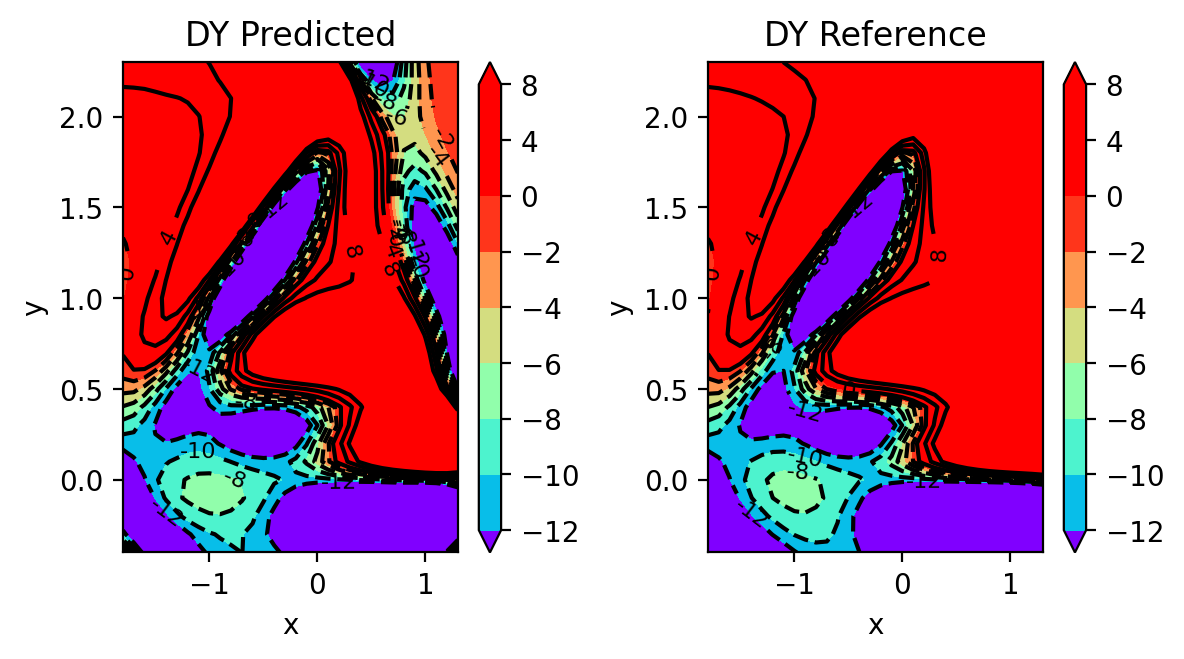

In [12]:
# Show the predicted surface, and compare to the reference one
def show_DY_surface():


  n1, n2 = 896, 1

  dy_pred = mean[:, 2]
  DY_pred = np.reshape(dy_pred.detach().numpy(),(len(yy),-1))
  DY_diff = np.subtract(DY_pred, DY)

  fig = plt.figure(figsize=(6,6), dpi=200)

  plt.subplot(2, 2, 1)
  levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8]
  ct = plt.contour(X, Y, DY_pred, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, DY_pred, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("DY Predicted")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(2, 2, 2)
  levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8]
  ct = plt.contour(X, Y, DY, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, DY, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("DY Reference")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.tight_layout()

  plt.show()

show_DY_surface()

Model Performance and Training Set Size
Be advised: $\textrm{Q}^2$ and RMSE values on the testing set will be high due to poor repersentation of the input space in the training set. To account for this, we will use the orginal 696 point training set as the testing set. 



In [47]:
print("Size of (current) training set:", Y_gpr.shape[0])

X_test = torch.clone(X_gpr)
Y_test = torch.clone(Y_gpr)

def evaluate_model(train_x, train_y, test_x, test_y, model):
  model.eval()
  preds_train = model(train_x).mean
  preds_test = model(test_x).mean
  if use_gpu:
    preds_train = preds_train.cpu()
    preds_test = preds_test.cpu()
    train_y = train_y.cpu()
    test_y = test_y.cpu()
  rmse_train_f = torch.sqrt(torch.mean((train_y[:,0] - preds_train[:,0])**2))
  rmse_test_f = torch.sqrt(torch.mean((test_y[:,0] - preds_test[:,0])**2))
  r2_f = 1 - torch.sum((train_y[:,0]-preds_train[:,0])**2)/torch.sum((train_y[:,0]-torch.mean(train_y[:,0]))**2)
  q2_f = 1 - torch.sum((test_y[:,0]-preds_test[:,0])**2)/torch.sum((test_y[:,0]-torch.mean(test_y[:,0]))**2)
  rmse_train_dfdx = torch.sqrt(torch.mean((train_y[:,1] - preds_train[:,1])**2))
  rmse_test_dfdx = torch.sqrt(torch.mean((test_y[:,1] - preds_test[:,1])**2))
  r2_dfdx = 1 - torch.sum((train_y[:,1]-preds_train[:,1])**2)/torch.sum((train_y[:,1]-torch.mean(train_y[:,1]))**2)
  q2_dfdx = 1 - torch.sum((test_y[:,1]-preds_test[:,1])**2)/torch.sum((test_y[:,1]-torch.mean(test_y[:,1]))**2)
  rmse_train_dfdy = torch.sqrt(torch.mean((train_y[:,2] - preds_train[:,2])**2))
  rmse_test_dfdy = torch.sqrt(torch.mean((test_y[:,2] - preds_test[:,2])**2))
  r2_dfdy = 1 - torch.sum((train_y[:,2]-preds_train[:,2])**2)/torch.sum((train_y[:,2]-torch.mean(train_y[:,2]))**2)
  q2_dfdy = 1 - torch.sum((test_y[:,2]-preds_test[:,2])**2)/torch.sum((test_y[:,2]-torch.mean(test_y[:,2]))**2)
  print("Function: ")
  print("Training Data - RMSE: %.3f R^2: %3f" % (rmse_train_f, r2_f))
  print("Teseting Data - RMSE: %.3f Q^2: %3f" % (rmse_test_f, q2_f))
  print("dfdx: ")
  print("Training Data - RMSE: %.3f R^2: %3f" % (rmse_train_dfdx, r2_dfdx))
  print("Teseting Data - RMSE: %.3f Q^2: %3f" % (rmse_test_dfdx, q2_dfdx))
  print("dfdy: ")
  print("Training Data - RMSE: %.3f R^2: %3f" % (rmse_train_dfdy, r2_dfdy))
  print("Teseting Data - RMSE: %.3f Q^2: %3f" % (rmse_test_dfdy, q2_dfdy))
  rmse_train = np.stack((rmse_train_f.detach().numpy(), rmse_train_dfdx.detach().numpy(), rmse_train_dfdx.detach().numpy()))
  r2 = np.stack((r2_f.detach().numpy(), r2_dfdx.detach().numpy(), r2_dfdy.detach().numpy()))
  rmse_test = np.stack((rmse_test_f.detach().numpy(), rmse_test_dfdx.detach().numpy(), rmse_test_dfdx.detach().numpy()))
  q2 = np.stack((q2_f.detach().numpy(), q2_dfdx.detach().numpy(), q2_dfdy.detach().numpy()))  
  return rmse_train, r2, rmse_test, q2


def reduce_training_set(train_x, train_y, new_size):
  arr_index = np.arange(train_y.shape[0])
  np.random.shuffle(arr_index)
  return train_x[arr_index[:new_size],:], train_y[arr_index[:new_size],:]

def new_model(train_x, train_y):
  likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)  # Value + x-derivative + y-derivative
  model = GPModelWithDerivatives(train_x, train_y, likelihood)
  model.train()
  likelihood.train()
  if use_gpu:
    model = model.cuda()
    likelihood = likelihood.cuda()
  train_model(model, likelihood, train_x, train_y, print_hp=False)
  return model

size_list = []
rmse_train_list = []
r2_list = []
rmse_test_list = []
q2_list = []

training_set_sizes = [696, 600, 500, 400, 300, 200, 100]
for set_size in training_set_sizes:
  X_gpr, Y_gpr = reduce_training_set(X_gpr, Y_gpr, set_size)
  if use_gpu:
    X_gpr = X_gpr.cuda()
    Y_gpr = Y_gpr.cuda()
  model = new_model(X_gpr, Y_gpr)
  rmse_train, r2, rmse_test, q2 = evaluate_model(X_gpr, Y_gpr, X_test, Y_test, model)
  size_list.append(set_size)
  for i in range(3):
    rmse_train_list.append(rmse_train[i])
    r2_list.append(r2[i])
    rmse_test_list.append(rmse_test[i])
    q2_list.append(q2[i])

function_set_dict = {
    'Training Set Size': size_list,
    'Training Set RMSE': rmse_train_list[::3],
    'R^2': r2_list[::3],
    'Testing Set RMSE': rmse_test_list[::3],
    'Q^2': q2_list[::3]
}

dfdx_set_dict = {
    'Training Set Size': size_list,
    'Training Set RMSE': rmse_train_list[1::3],
    'R^2': r2_list[1::3],
    'Testing Set RMSE': rmse_test_list[1::3],
    'Q^2': q2_list[1::3]
}

dfdy_set_dict = {
    'Training Set Size': size_list,
    'Training Set RMSE': rmse_train_list[2::3],
    'R^2': r2_list[2::3],
    'Testing Set RMSE': rmse_test_list[2::3],
    'Q^2': q2_list[2::3]
}

Size of (current) training set: 696


/usr/local/lib/python3.7/dist-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


Function: 
Training Data - RMSE: 0.086 R^2: 0.999719
Teseting Data - RMSE: 0.086 Q^2: 0.999719
dfdx: 
Training Data - RMSE: 0.687 R^2: 0.998205
Teseting Data - RMSE: 0.687 Q^2: 0.998205
dfdy: 
Training Data - RMSE: 0.643 R^2: 0.998883
Teseting Data - RMSE: 0.643 Q^2: 0.998883
Function: 
Training Data - RMSE: 0.106 R^2: 0.999573
Teseting Data - RMSE: 0.108 Q^2: 0.999554
dfdx: 
Training Data - RMSE: 0.709 R^2: 0.998129
Teseting Data - RMSE: 0.818 Q^2: 0.997451
dfdy: 
Training Data - RMSE: 0.657 R^2: 0.998865
Teseting Data - RMSE: 0.682 Q^2: 0.998743
Function: 
Training Data - RMSE: 0.093 R^2: 0.999676
Teseting Data - RMSE: 0.110 Q^2: 0.999539
dfdx: 
Training Data - RMSE: 0.742 R^2: 0.997857
Teseting Data - RMSE: 1.448 Q^2: 0.992020
dfdy: 
Training Data - RMSE: 0.644 R^2: 0.998918
Teseting Data - RMSE: 1.026 Q^2: 0.997158
Function: 
Training Data - RMSE: 0.124 R^2: 0.999438
Teseting Data - RMSE: 0.150 Q^2: 0.999137
dfdx: 
Training Data - RMSE: 0.820 R^2: 0.997311
Teseting Data - RMSE: 1.6

In [48]:
import tabulate
print("function: ")
print(tabulate.tabulate(function_set_dict, headers = 'keys'))
print("dfdx: ")
print(tabulate.tabulate(dfdx_set_dict, headers = 'keys'))
print("dfdy: ")
print(tabulate.tabulate(dfdy_set_dict, headers = 'keys'))

function: 
  Training Set Size    Training Set RMSE       R^2    Testing Set RMSE       Q^2
-------------------  -------------------  --------  ------------------  --------
                696            0.0858128  0.999719           0.0858128  0.999719
                600            0.105985   0.999573           0.108121   0.999554
                500            0.0933185  0.999676           0.109947   0.999539
                400            0.124336   0.999438           0.15045    0.999137
                300            0.138897   0.99933            0.188852   0.99864
                200            0.177655   0.998895           0.321566   0.996058
                100            0.330042   0.995864           0.970326   0.964109
dfdx: 
  Training Set Size    Training Set RMSE       R^2    Testing Set RMSE       Q^2
-------------------  -------------------  --------  ------------------  --------
                696             0.68667   0.998205            0.68667   0.998205
           

In [ ]:
#!pip install functorch > /dev/null
#import functorch

In [ ]:
class RBFKernelAutoGrad(gpytorch.kernels.rbf_kernel.RBFKernel):
    def forward(self, x1, x2=None, diag=False, **params):
        if x2 is None:
            x2 = torch.clone(x1)
        batch_shape = x1.shape[:-2] # Code will need to be update for batch training
        n_batch_dims = len(batch_shape) # These two lines will act as place holders
        nx1, ndim1 = x1.shape[-2:]
        nx2, ndim2 = x2.shape[-2:]

        K = torch.zeros(*batch_shape, nx1 * (ndim1 + 1), nx2 * (ndim2 + 1), device=x1.device, dtype=x1.dtype)
        if not diag:
            # 1) Kernel Block
            K00 = super().forward(x1,x2)
            # 2) First Gradient Block
            dkdx1_, dkdx2_ = torch.autograd.functional.jacobian(super().forward, (x1,x2))
            #dkdx1 = torch.tensordot(torch.eye(K00.shape[0]),dkdx1_.permute(2,0,1,3),dims=2)
            dkdx1 = 1 * torch.einsum("ji,ijkl->jkl", torch.eye(K00.shape[0]),dkdx1_.permute(2,0,1,3))
            dkdx2 = 1 * torch.einsum("ji,ijkl->jkl", torch.eye(K00.shape[1]),dkdx2_.permute(2,1,0,3))
            d2kdx1dx2 = -1 * torch.einsum("ji,ijklm->jklm", torch.eye(K00.shape[0]), torch.einsum("ji,ijklmn->jklmn", torch.eye(K00.shape[0]),functorch.hessian(super().forward)(x1,x2).permute(4,0,2,1,3,5)))

            # Assemble Extended Kernel to Match MultiTask ordering
            K[...,:nx1, :nx2] = K00
            K[...,:nx1,nx2:] = dkdx2.permute(1,2,0).reshape([nx1,nx2*ndim2])
            K[...,nx1:,:nx2] = dkdx1.permute(2,0,1).reshape([nx1*ndim1, nx2])
            K[...,nx1:,nx2:] = torch.reshape(d2kdx1dx2.permute(3,0,2,1), [nx1*ndim1, nx2*ndim2])

            # Apply a perfect shuffle permutation to match the MutiTask ordering
            pi1 = torch.arange(nx1 * (ndim1 + 1)).view(ndim1 + 1, nx1).t().reshape((nx1 * (ndim1 + 1)))
            pi2 = torch.arange(nx2 * (ndim1 + 1)).view(ndim2 + 1, nx2).t().reshape((nx2 * (ndim2 + 1)))
            K = K[..., pi1, :][..., :, pi2]

            # Symmetrize for stability
            if nx1 == nx2 and torch.eq(x1, x2).all():
                K = 0.5 * (K.transpose(-1, -2) + K)
            return K
        else:
            if not (nx1 == nx2 and torch.eq(x1, x2).all()):
                raise RuntimeError("diag=True only works when x1 == x2")

    def num_outputs_per_input(self, x1, x2):
        return x1.size(-1) + 1

class GPModelWithAutoDerivatives(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelWithAutoDerivatives, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = RBFKernelAutoGrad(ard_num_dims=2)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

Z_gpr = Tensor(z_truncated)
DX_gpr = Tensor(dx_truncated)
DY_gpr = Tensor(dy_truncated)

X_gpr = Tensor(xy_truncated)
Y_gpr = torch.stack([Z_gpr, DX_gpr, DY_gpr], -1).squeeze(1)

def reduce_training_set(train_x, train_y, new_size):
  arr_index = np.arange(train_y.shape[0])
  np.random.shuffle(arr_index)
  return train_x[arr_index[:new_size],:], train_y[arr_index[:new_size],:]
X_gpr, Y_gpr = reduce_training_set(X_gpr, Y_gpr, 50)
print(X_gpr.shape, Y_gpr.shape)
print(X_gpr.shape, Y_gpr.shape)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)  # Value + x-derivative + y-derivative
model = GPModelWithAutoDerivatives(X_gpr, Y_gpr, likelihood)

model.covar_module.outputscale = 2.6
model.covar_module.base_kernel.lengthscale = [0.275, 0.240]
model.likelihood.noise = 0.41


In [ ]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 10

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_gpr)
    loss = -mll(output, Y_gpr)
    loss.backward()
    print("Iter %d/%d - Loss: %.3f   lengthscales: %.3f, %.3f   noise: %.3f" % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.squeeze()[0],
        model.covar_module.base_kernel.lengthscale.squeeze()[1],
        model.likelihood.noise.item()
    ))
    optimizer.step()